In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from my_utilities import read_data

In [2]:
# read the data
whole_data, tr_data, ts_data = read_data()

Check the p-value of the whole series, training data e test data to check if it's stationary

In [3]:
pvalue = adfuller(whole_data)[1]
print('p-value of the whole series: %f' % pvalue)
pvalue = adfuller(tr_data)[1]
print('p-value of the training data: %f' % pvalue)
pvalue = adfuller(ts_data)[1]
print('p-value of the test data: %f' % pvalue)

p-value of the whole series: 0.000000
p-value of the training data: 0.000000
p-value of the test data: 0.000000


They are all stationary

To find the **AR order**, plot the **partial autocorrelation**

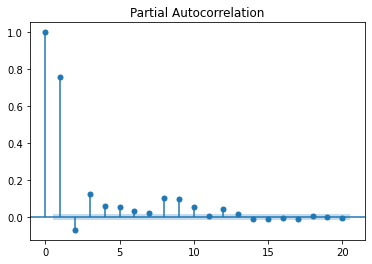

In [4]:
plot_pacf(tr_data, lags=20)
plt.show()

Set the AR order

In [5]:
ar_order = 5

To find the **MA order**, plot the **autocorrelation**

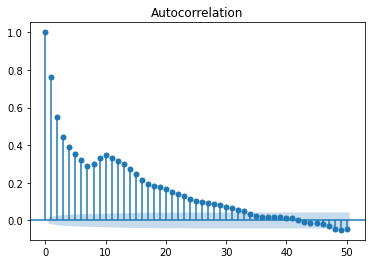

In [6]:
plot_acf(tr_data, lags=50)
plt.show()

Set the MA order

In [7]:
ma_order = 3

Create and fit an AR model, a MA one and an ARMA one

In [9]:
ar = ARIMA(endog=tr_data, order=(ar_order, 0, 0))
ma = ARIMA(endog=tr_data, order=(0, 0, ma_order))
arma = ARIMA(endog=tr_data, order=(ar_order, 0, ma_order))
res_ar = ar.fit()
res_ma = ma.fit()
res_arma = arma.fit()

Check the models' coefficients to see if there are irrelevant ones

In [10]:
print(f"AR model's coefficients: {res_ar.arparams}")
print(f"MA model's coefficients: {res_ma.maparams}")
print(f"ARMA model's AR coefficients: {res_arma.arparams}")
print(f"ARMA model's MA coefficients: {res_arma.maparams}")

AR model's coefficients: [ 0.81202175 -0.16319037  0.07975819  0.01541432  0.05563371]
MA model's coefficients: [0.83532467 0.48908294 0.21892564]
ARMA model's AR coefficients: [ 0.2622909   0.90451224 -0.08570204 -0.19385362  0.0527056 ]
ARMA model's MA coefficients: [ 0.53637449 -0.64691054 -0.45032385]


We can see that some coefficients are near zero.
Let's try to change them a bit:

In [3]:
ar_order = 3
ma_order = 4
arma_ar_order = 3
arma_ma_order = 1
ar = ARIMA(endog=tr_data, order=(ar_order, 0, 0))
ma = ARIMA(endog=tr_data, order=(0, 0, ma_order))
arma = ARIMA(endog=tr_data, order=(arma_ar_order, 0, arma_ma_order))
res_ar = ar.fit()
res_ma = ma.fit()
res_arma = arma.fit()
print(f"AR model's coefficients: {res_ar.arparams}")
print(f"MA model's coefficients: {res_ma.maparams}")
print(f"ARMA model's AR coefficients: {res_arma.arparams}")
print(f"ARMA model's MA coefficients: {res_arma.maparams}")

d:\projects\ispr-midterms\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\projects\ispr-midterms\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR model's coefficients: [ 0.82274631 -0.16953783  0.12089911]
MA model's coefficients: [0.84547571 0.51511217 0.30238695 0.13767543]
ARMA model's AR coefficients: [ 1.62896096 -0.81327326  0.16156719]
ARMA model's MA coefficients: [-0.83525517]


These coefficients look pretty good, no one is too near to zero.

Make **predictions** with retraining for one day.<br>
**AR model**:

  0%|          | 0/144 [00:00<?, ?it/s]

MEE:  34.957801785033226
MAPE:  34.957801785033226


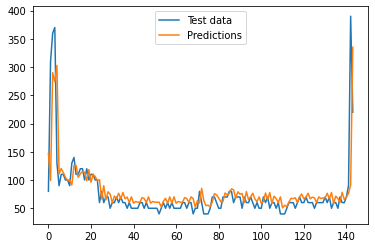

In [17]:
# err = 0
predictions = []
for i in tqdm(range(24*6)):
    predictions.append(res_ar.forecast(steps=1))
    # curr_err = abs(predictions[-1] - ts_data[i])
    # err += curr_err
    tr_data = np.concatenate((tr_data, [ts_data[i]]))
    ar = ARIMA(endog=tr_data, order=(ar_order, 0, 0))
    res_ar = ar.fit()

# err /= len(ts_data)
# print("Average error: ", err)
mee = np.mean(np.abs(np.subtract(predictions, ts_data[:24*6])))
# mape = np.mean(np.abs(predictions - ts_data[:24*6])/np.abs(ts_data[:24*6]))
mape = np.mean(np.divide(
    np.abs(np.subtract(predictions, ts_data[:24*6])),
    np.abs(ts_data[:24*6])
))
print("MEE: ", mee)
print("MAPE: ", mee)
plt.plot(ts_data[:24*6], label="Test data")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()

**MA model**:

  0%|          | 0/144 [00:00<?, ?it/s]

Average error:  [0.45671562]


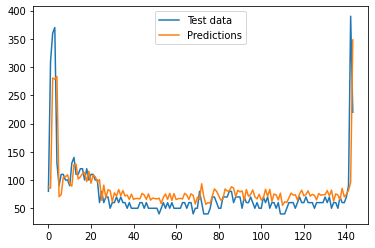

In [13]:
_, tr_data, ts_data = read_data()
err = 0
predictions = []
for i in tqdm(range(24*6)):
    predictions.append(res_ma.forecast(steps=1))
    curr_err = abs(predictions[-1] - ts_data[i])
    err += curr_err
    tr_data = np.concatenate((tr_data, [ts_data[i]]))
    ma = ARIMA(endog=tr_data, order=(0, 0, ma_order))
    res_ma = ma.fit()

err /= len(ts_data)
print("Average error: ", err)
plt.plot(ts_data[:24*6], label="Test data")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()

**ARMA model**:

  0%|          | 0/288 [00:00<?, ?it/s]

Average error:  [1.29411007]


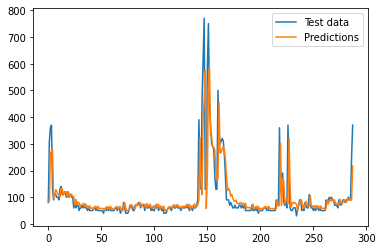

In [12]:
_, tr_data, ts_data = read_data()
err = 0
predictions = []
for i in tqdm(range(48*6)):
    predictions.append(res_arma.forecast(steps=1))
    curr_err = abs(predictions[-1] - ts_data[i])
    err += curr_err
    tr_data = np.concatenate((tr_data, [ts_data[i]]))
    arma = ARIMA(endog=tr_data, order=(arma_ar_order, 0, arma_ma_order))
    res_arma = arma.fit()

err /= len(ts_data)
print("Average error: ", err)
plt.plot(ts_data[:48*6], label="Test data")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()
